In [20]:
import umap
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
'''
d = "/mnt/c/Users/trang.le/Desktop/shapemode"
PC = "PC1"
df0 = pd.read_csv(f"{d}/covar_sc/{PC}_0_intensities.csv")
#df1 = pd.read_csv(f"{d}/covar_sc/{PC}_1_intensities.csv")
df0 = df0.drop("Unnamed: 0", axis=1)
df0 = df0[df0.cell_labs != 'Multi-Location']
intensities = df0.iloc[:10000,254:5376].values
reducer=umap.UMAP(n_neighbors=15, min_dist= 0.1, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(intensities)
print(embedding.shape)
#plt.scatter(embedding[:,0], embedding[:,1], c=df0.cell_labs)
plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:,0], embedding[:,1],
                hue=df0[df0.cell_labs != 'Multi-Location'].cell_labs[:10000].to_list(),
                alpha=1, s=4)
'''

'\nd = "/mnt/c/Users/trang.le/Desktop/shapemode"\nPC = "PC1"\ndf0 = pd.read_csv(f"{d}/covar_sc/{PC}_0_intensities.csv")\n#df1 = pd.read_csv(f"{d}/covar_sc/{PC}_1_intensities.csv")\ndf0 = df0.drop("Unnamed: 0", axis=1)\ndf0 = df0[df0.cell_labs != \'Multi-Location\']\nintensities = df0.iloc[:10000,254:5376].values\nreducer=umap.UMAP(n_neighbors=15, min_dist= 0.1, n_components=2, metric=\'euclidean\')\nembedding = reducer.fit_transform(intensities)\nprint(embedding.shape)\n#plt.scatter(embedding[:,0], embedding[:,1], c=df0.cell_labs)\nplt.figure(figsize=(10,10))\nsns.scatterplot(embedding[:,0], embedding[:,1],\n                hue=df0[df0.cell_labs != \'Multi-Location\'].cell_labs[:10000].to_list(),\n                alpha=1, s=4)\n'

In [22]:
import sys
sys.path.append("..")
import configs.config as cfg
#embedding = pd.read_csv(cfg.META_PATH)
embedding = pd.read_csv(f"{cfg.PROJECT_DIR}/sl_pHPA_15_0.05_euclidean_100000_rmoutliers_ilsc_3d_bbox_rm_border_splitVesiclesPCP.csv")
shapemode_dir = f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}"
df_trans = pd.read_csv(f"{shapemode_dir}/transformed_matrix.csv")

In [23]:
shapemode_dir

'/data/2Dshapespace/U2OS/shapemode/fft_cell_major_axis_polarized_cell_nuclei'

In [24]:
from utils.helpers_hierarchy import factorize_into_quantiles
n = 3
pc_cells, quantiles, df_trans_tmp = factorize_into_quantiles(df_trans, "PC1", n)
df_trans_tmp['cell_idx'] = [f.split("/")[-1].split(".")[0] for f in df_trans_tmp['Unnamed: 0']]

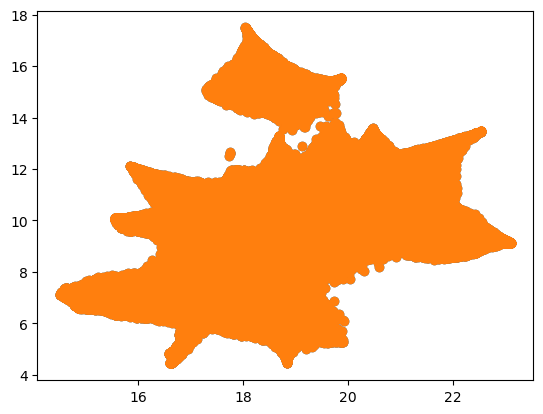

In [25]:
tmp = pd.merge(df_trans_tmp[['PC1', 'groups','cell_idx']], embedding, on='cell_idx', how='inner')
# Find all proteins present in bin 0 vs 2
for g in [0, 2]:
    plt.scatter(tmp.x, tmp.y)#, c=tmp.sc_target)

In [26]:
tmp.columns

Index(['PC1', 'groups', 'cell_idx', 'x', 'y', 'z', 'id', 'location',
       'location_code', 'locations', 'gene_names', 'ensembl_ids', 'atlas_name',
       'ImageWidth', 'top', 'left', 'width', 'height', 'target', 'image_id',
       'cell_id', 'nucleus_area', 'cell_area', 'sc_locations', 'sc_target'],
      dtype='object')

In [27]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def build_knn_graph(data, n_neighbors=15):
    """Construct a k-nearest neighbor graph from the data using a sparse matrix."""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    knn_graph = nbrs.kneighbors_graph(data, mode='connectivity')  # Sparse matrix
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(edges=list(zip(sources, targets)), directed=False)
    g.vs["name"] = list(range(data.shape[0]))  # Assign node IDs
    return g

In [29]:
tmp['Protein'] = [f.split(',')[0] for f in tmp.gene_names]
tmp[['x','y','z','Protein']].groupby('Protein', as_index=False).mean()#.sort_values('x')

Protein          x          y          z
0       AAAS  18.571331   8.065919  12.340960
1       AACS  17.985331  10.572574   4.917636
2      AADAT  18.051418   6.918002   7.127965
3      AAGAB  17.928626   7.957728  10.160699
4       AAK1  17.367386   7.578897   6.535600
...      ...        ...        ...        ...
9748   ZWINT  20.112606  12.261594   7.910813
9749    ZXDA  20.500496  12.019327   9.232451
9750    ZXDC  18.170471  14.186968   8.966956
9751  ZYG11B  17.717369   9.969604   5.294627
9752     ZYX  19.492975   5.908764   7.258329

[9753 rows x 4 columns]

In [30]:
labels_df

NameError: name 'labels_df' is not defined

In [31]:
import numpy as np
labels_df = tmp[['x','y','z','Protein']].groupby('Protein', as_index=False).mean()
reduced_data = labels_df[['x', 'y','z']].values
resolutions = [0, 0.4, 0.6, 1]
neighbors = [5, 10, 40, 100]

# Initialize variables
current_labels = pd.DataFrame(index=np.arange(len(reduced_data)), columns=['Cluster'])
current_labels['Cluster'] = 0  # Start with all data in one cluster
# Hierarchical clustering loop
for i, (res, n_neighbors) in enumerate(zip(resolutions, neighbors)):
    print(f"\nLevel {i}: n_neighbors={n_neighbors}, resolution={res}")
    new_labels = current_labels.copy()

    for parent_cluster_id in current_labels['Cluster'].unique():
        # Extract indices and data for the current cluster
        indices = current_labels.index[current_labels['Cluster'] == parent_cluster_id]
        sub_data = reduced_data[indices]

        
        # Skip clustering if the sub-cluster is too small
        if len(sub_data) < n_neighbors:
            print(f"Skipping cluster {parent_cluster_id} as it contains fewer than {n_neighbors} points.")
            continue

        # Build k-NN graph for this cluster
        sub_graph = build_knn_graph(sub_data, n_neighbors=n_neighbors)

        # Perform Leiden clustering
        partition = la.find_partition(sub_graph, la.RBConfigurationVertexPartition, resolution_parameter=res)
        num_sub_clusters = len(set(partition.membership))
        #print(f"Cluster {parent_cluster_id}: Found {num_sub_clusters} sub-clusters.")

        # Update labels for the sub-clusters
        for local_id, global_id in enumerate(set(partition.membership)):
            global_cluster_id = f"{parent_cluster_id}.{global_id}"  # Unique global ID for this level
            membership_array = np.array(partition.membership)
            new_labels.loc[indices[membership_array == local_id], 'Cluster'] = global_cluster_id
        
    labels_df[f'Cluster_res{res}_neigh{n_neighbors}'] = new_labels.Cluster
    # Update the current labels for the next iteration
    current_labels = new_labels
    print(f'Level {i} has {len(set(current_labels.Cluster))} clusters')

# Print the summary
print(labels_df)



Level 0: n_neighbors=5, resolution=0


/tmp/ipykernel_380053/3446210727.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_labels.loc[indices[membership_array == local_id], 'Cluster'] = global_cluster_id


Level 0 has 2 clusters

Level 1: n_neighbors=10, resolution=0.4
Level 1 has 20 clusters

Level 2: n_neighbors=40, resolution=0.6
Skipping cluster 0.1.0 as it contains fewer than 40 points.
Level 2 has 84 clusters

Level 3: n_neighbors=100, resolution=1
Skipping cluster 0.0.6.4 as it contains fewer than 100 points.
Skipping cluster 0.0.3.5 as it contains fewer than 100 points.
Skipping cluster 0.0.14.1 as it contains fewer than 100 points.
Skipping cluster 0.0.15.1 as it contains fewer than 100 points.
Skipping cluster 0.0.10.2 as it contains fewer than 100 points.
Skipping cluster 0.0.7.3 as it contains fewer than 100 points.
Skipping cluster 0.0.7.1 as it contains fewer than 100 points.
Skipping cluster 0.0.3.4 as it contains fewer than 100 points.
Skipping cluster 0.0.18.0 as it contains fewer than 100 points.
Skipping cluster 0.0.17.1 as it contains fewer than 100 points.
Skipping cluster 0.0.14.2 as it contains fewer than 100 points.
Skipping cluster 0.0.7.4 as it contains fewer th

In [32]:
#labels_df["Protein"] = [f.split(',')[0] for f in labels_df.gene_names]
labels_df

Protein          x          y          z Cluster_res0_neigh5  \
0       AAAS  18.571331   8.065919  12.340960                 0.0   
1       AACS  17.985331  10.572574   4.917636                 0.0   
2      AADAT  18.051418   6.918002   7.127965                 0.0   
3      AAGAB  17.928626   7.957728  10.160699                 0.0   
4       AAK1  17.367386   7.578897   6.535600                 0.0   
...      ...        ...        ...        ...                 ...   
9748   ZWINT  20.112606  12.261594   7.910813                 0.0   
9749    ZXDA  20.500496  12.019327   9.232451                 0.0   
9750    ZXDC  18.170471  14.186968   8.966956                 0.0   
9751  ZYG11B  17.717369   9.969604   5.294627                 0.0   
9752     ZYX  19.492975   5.908764   7.258329                 0.0   

     Cluster_res0.4_neigh10 Cluster_res0.6_neigh40 Cluster_res1_neigh100  
0                     0.0.4                0.0.4.2             0.0.4.2.1  
1                     0.0.6                0.0.6.4               0.0.6.4  
2                     0.0.5                0.0.5.2             0.0.5.2.0  
3                     0.0.3                0.0.3.5               0.0.3.5  
4                     0.0.1                0.0.1.0             0.0.1.0.0  
...                     ...                    ...                   ...  
9748                  0.0.0                0.0.0.4               0.0.0.4  
9749                  0.0.0                0.0.0.2             0.0.0.2.1  
9750                 0.0.10               0.0.10.0            0.0.10.0.0  
9751                  0.0.6                0.0.6.4               0.0.6.4  
9752                  0.0.5                0.0.5.3             0.0.5.3.1  

[9753 rows x 8 columns]

In [33]:
import gseapy
databases = [
        #"GO_Biological_Process_2021",
        "GO_Cellular_Component_2021",
        #"GO_Molecular_Function_2021",
        #"WikiPathway_2021_Human",
        #"KEGG_2021_Human",
    ]
# Enrichment analysis for each cluster
cluster_enrichments = {}
clusters_genes = {}

for level, (res, n_neighbors) in enumerate(zip(resolutions, neighbors)):
    clusters_genes[res] = {}
    cluster_enrichments[res] = {}
    for cluster, cells in labels_df.groupby(f'Cluster_res{res}_neigh{n_neighbors}'):
        members = list(set(cells.Protein.values))
        enr = gseapy.enrichr(
                gene_list=members,
                gene_sets=databases
            )
        if enr.results.shape[0] == 0 or enr.results["Adjusted P-value"].min() >= 0.05:
            enrichment_term = "NA"
        else:
            enrichment_term = enr.results[enr.results["Adjusted P-value"] < 0.05].iloc[0]["Term"]
        #print(len(members), enr.results[enr.results["Adjusted P-value"] < 0.05])
        cluster_enrichments[res][cluster] = enrichment_term
        clusters_genes[res][cluster] = set(cells.Protein.values)
cluster_enrichments


{0: {'0.0': 'intracellular membrane-bounded organelle (GO:0043231)',
  '0.1': 'nucleus (GO:0005634)'},
 0.4: {'0.0.0': 'nucleus (GO:0005634)',
  '0.0.1': 'polymeric cytoskeletal fiber (GO:0099513)',
  '0.0.10': 'nucleolus (GO:0005730)',
  '0.0.11': 'mitochondrial membrane (GO:0031966)',
  '0.0.12': 'nucleus (GO:0005634)',
  '0.0.13': 'azurophil granule (GO:0042582)',
  '0.0.14': 'endoplasmic reticulum membrane (GO:0005789)',
  '0.0.15': 'mitochondrial membrane (GO:0031966)',
  '0.0.16': 'nucleus (GO:0005634)',
  '0.0.17': 'nuclear membrane (GO:0031965)',
  '0.0.18': 'cytosolic large ribosomal subunit (GO:0022625)',
  '0.0.2': 'ribosome (GO:0005840)',
  '0.0.3': 'nucleus (GO:0005634)',
  '0.0.4': 'nucleus (GO:0005634)',
  '0.0.5': 'cell-substrate junction (GO:0030055)',
  '0.0.6': 'bounding membrane of organelle (GO:0098588)',
  '0.0.7': 'intracellular membrane-bounded organelle (GO:0043231)',
  '0.0.8': 'nucleus (GO:0005634)',
  '0.0.9': 'nucleus (GO:0005634)',
  '0.1.0': 'nucleus (GO:

In [1]:
import networkx as nx
# Create a graph
G = nx.DiGraph()

# Step 2: Create nodes for the graph
for res in resolutions:
    for cluster in clusters_genes[res]:
        G.add_node((res, cluster), genes=clusters_genes[res][cluster])

# Step 3: Create edges between nodes
for i in range(len(resolutions) - 1):
    res_i = resolutions[i]
    res_j = resolutions[i + 1]
    for cluster_i in clusters_genes[res_i]:
        genes_i = clusters_genes[res_i][cluster_i]
        for cluster_j in clusters_genes[res_j]:
            genes_j = clusters_genes[res_j][cluster_j]
            if len(genes_j.intersection(genes_i)) / len(genes_j) > 0.9:
                G.add_edge((res_i, cluster_i), (res_j, cluster_j))


# Step 4: Visualize the graph
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB -Gnodesep=1")

# Plot the graph
plt.figure(figsize=(40, 20))
nx.draw(
    G,
    pos,
    with_labels=False,
    arrows=True,
    node_size=700,
    node_color="lightblue",
    arrowstyle="->",
)

plt.title("Hierarchical Cluster Tree")
plt.axis("off")
plt.show()

NameError: name 'resolutions' is not defined

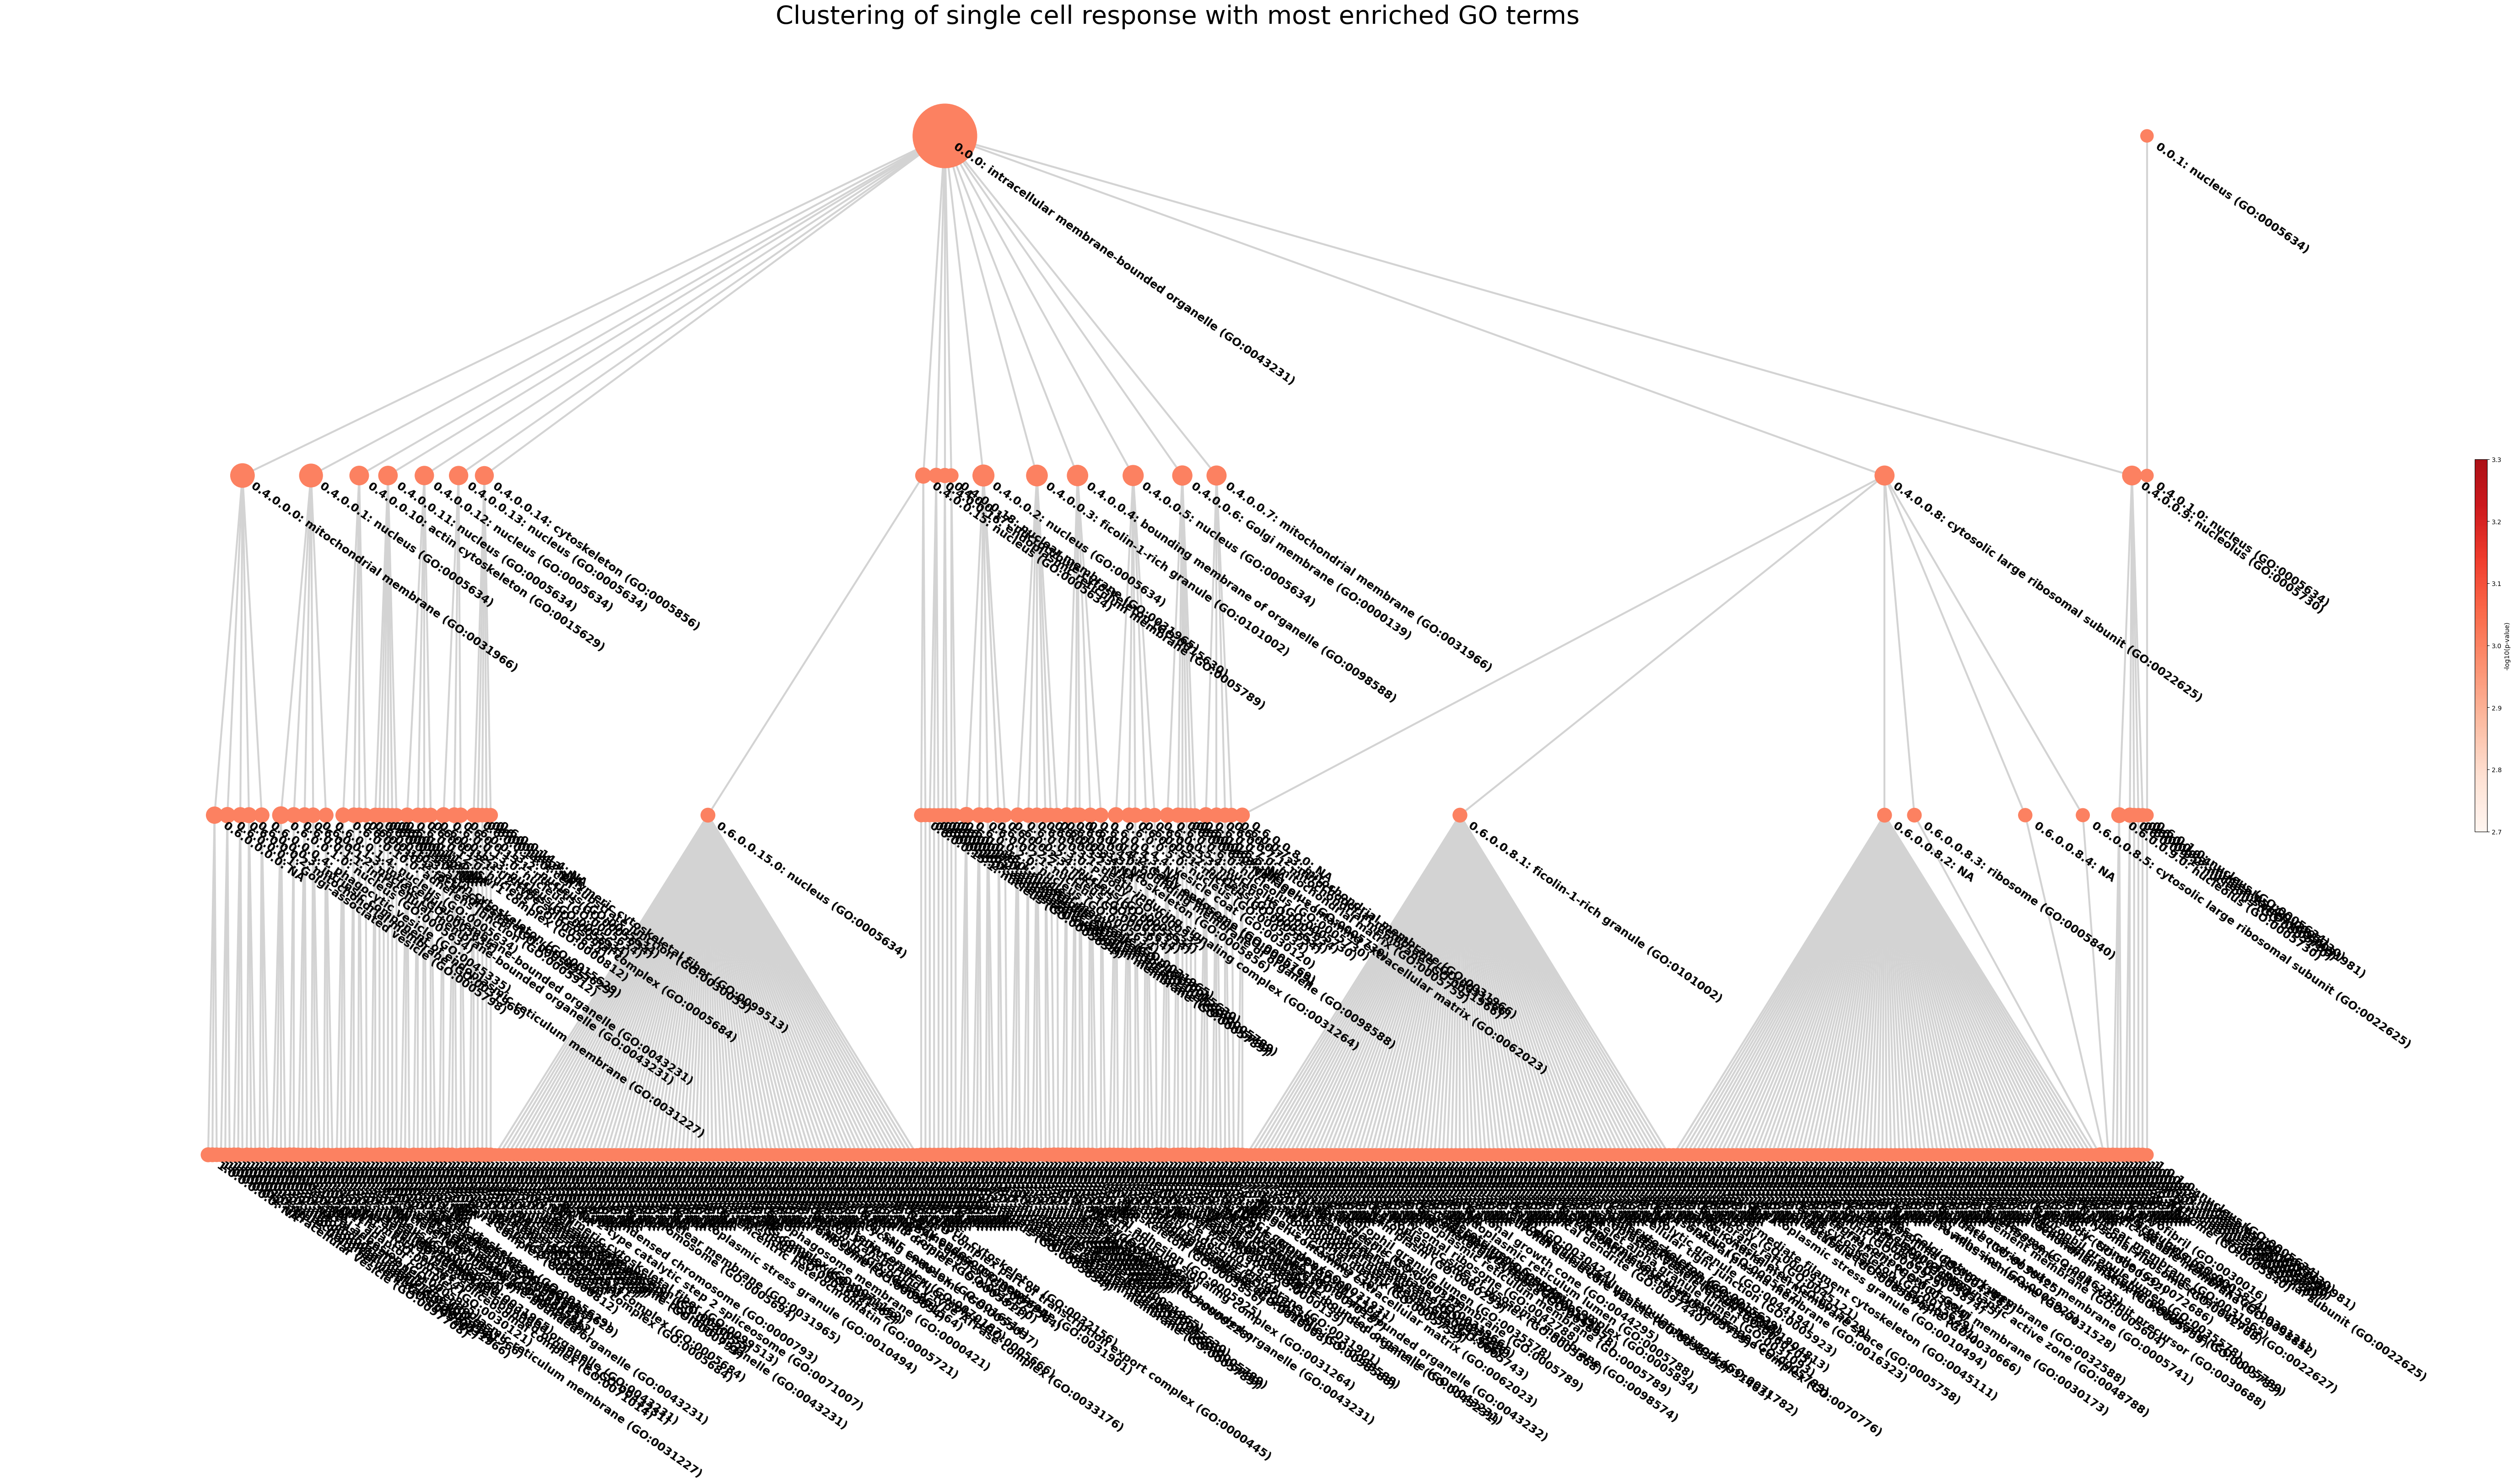

In [ ]:
import matplotlib.colors as mcolors
# Adjust the Reds colormap to remove the last 15% of the colors
cmap = plt.get_cmap("Reds")
truncated_cmap = mcolors.LinearSegmentedColormap.from_list(
    "truncated_reds", cmap(np.linspace(0, 0.85, 256))
)

# Create node labels based on the most significant term and calculate node size and color
# level_dict = {0: 1, 0.15: 2, 0.2: 3, 0.25: 4, 0.3: 5, 0.33: 6, 0.36: 7}

node_sizes = []
node_colors = []
label_dict = {}

# Iterate over each node in the graph
for node in G.nodes:
    # Calculate node size based on the number of genes
    num_genes = len(G.nodes[node]["genes"])
    node_sizes.append(400 + num_genes)  # Scale the size for better visualization
    cluster = f"{node[1]}"
    res = node[0]

    # Check if there are enrichment results for the node
    if cluster_enrichments[res][cluster] is not None: # and not cluster_enrichments[res][cluster].empty:
        most_significant_term = cluster_enrichments[res][cluster]

        # Create a label for the node based on the most significant term
        label_dict[node] = most_significant_term
        label = f"  {res}.{cluster}: {most_significant_term}"
        p_value = 0.001 #most_significant_term["p_value"]

        # Calculate node color based on the -log10(p-value)
        node_colors.append((-np.log10(p_value)).clip(0, 50))

    else:
        # If no enrichment, set a default label and color
        label = f"  {res}.{cluster}: -"
        node_colors.append(0)  # No enrichment, set color to 0

    # Set the label for the node
    G.nodes[node]["label"] = label

# Visualize the graph with labels rotated by 45 degrees, node sizes, and colors
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(
    G, prog="dot", args="-Grankdir=TB -Gnodesep=300 -Granksep=3000"
)
'''
# Manually adjust positions of specific nodes for better visualization
node_to_move = (0.15, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.85, pos[node_to_move][1])

node_to_move = (0.15, "1")
pos[node_to_move] = (pos[node_to_move][0] * 1.05, pos[node_to_move][1])

node_to_move = (0.2, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.78, pos[node_to_move][1])

node_to_move = (0.2, "3")
pos[node_to_move] = (pos[node_to_move][0] * 0.93, pos[node_to_move][1])

node_to_move = (0.25, "5")
pos[node_to_move] = (pos[node_to_move][0] * 0.975, pos[node_to_move][1])
'''
# Create a figure for the plot
plt.figure(figsize=(70, 35))

# Draw the nodes with specified sizes and colors
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=truncated_cmap
)

# Draw the edges with a light gray color
edges = nx.draw_networkx_edges(G, pos, edge_color="#D3D3D3", width=3, arrows=False)

# Get the labels for the nodes
labels = nx.get_node_attributes(G, "label")

# Add text labels to the nodes
for key, (x, y) in pos.items():
    plt.text(
        x,
        y,
        labels[key],
        fontsize=18,
        fontweight="bold",
        ha="left",
        va="top",
        rotation=-35,
    )

# Add a colorbar to the plot
plt.colorbar(
    nodes, label="-log10(p-value)", fraction=0.005, location="right", aspect=30
)

# Add a title to the plot
plt.title(
    "Clustering of single cell response with most enriched GO terms",
    fontsize=40,
)

# Remove the axis frame
plt.axis("off")

# Save the plot as an SVG file
plt.savefig(
    f"U2OS_all_subclustering_hierarchy_graph_go_cc.svg",
    format="svg",
    bbox_inches="tight",
)

# Display the plot
plt.show()